<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_A2C_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
#!pip install box2d-py
import numpy as np 
import mxnet as mx 
from mxnet import gluon,autograd,nd
import mxnet.ndarray as F
from mxnet.gluon import nn
from mxnet.gluon.loss import L2Loss
import gym
from mxnet import init
import matplotlib.pyplot as plt

# hyperparams

In [0]:
env_name = "CartPole-v1"
solved_reward = 500 
log_interval = 10
lr = 0.001
gamma = 0.99               

# env

In [3]:
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim,action_dim)

4 2


# ActorCritic model

In [0]:
class ActorCritic_Discrete(nn.HybridBlock):
  def __init__(self, actions_dim):
    super().__init__()
    with self.name_scope():
      self.fc1 = nn.Dense(128,activation='tanh')
      self.fc2 = nn.Dense(128,activation='relu')
      self.action_pred = nn.Dense(actions_dim)
      self.value_pred = nn.Dense(1)
  def hybrid_forward(self,F,x):
    x = self.fc1(x)
    x = self.fc2(x)
    probs = self.action_pred(x)
    values = self.value_pred(x)
    return F.softmax(probs), values

# forward test

In [5]:
state = env.reset()
state = nd.array([state])

a = ActorCritic_Discrete(action_dim)
b = ActorCritic_Discrete(action_dim)

a.initialize(init=init.Xavier())
b.initialize(init=init.Xavier())

a.hybridize()
b.hybridize()

print(a(state))
print(b(state))

[
[[0.49933335 0.5006667 ]]
<NDArray 1x2 @cpu(0)>, 
[[0.00294055]]
<NDArray 1x1 @cpu(0)>]
[
[[0.49908295 0.5009171 ]]
<NDArray 1x2 @cpu(0)>, 
[[0.00337218]]
<NDArray 1x1 @cpu(0)>]


# copy params test

In [6]:
a.save_parameters("temp")
b.load_parameters("temp")

print(a(state))
print(b(state))

[
[[0.49933335 0.5006667 ]]
<NDArray 1x2 @cpu(0)>, 
[[0.00294055]]
<NDArray 1x1 @cpu(0)>]
[
[[0.49933335 0.5006667 ]]
<NDArray 1x2 @cpu(0)>, 
[[0.00294055]]
<NDArray 1x1 @cpu(0)>]


# model save test

In [0]:
a.export('test_save_model')
b.export('test_save_model')

# initialize

In [0]:
loss = gluon.loss.L2Loss()

model = ActorCritic_Discrete(action_dim)
model.collect_params().initialize(mx.init.Xavier())
model.hybridize()

optimizer = gluon.Trainer(model.collect_params(),'Adam',{'learning_rate':lr})

# main loop

In [9]:
all_rewards = []
avg_rewards = []

for episode in range(1000):

  # reset placeholder
  rewards = []
  values = []
  actions = []
  heads = []
  state = env.reset()
  total = 0
  
  with autograd.record():
    for learning_step in range(1000):
      
      # nd_array state
      state = nd.array(np.expand_dims(state, 0))
      
      # choose action and do action on env
      prob, value = model(state)
      action, logp = mx.nd.sample_multinomial(prob, get_prob=True)
      action = action.asnumpy()[0].astype(np.int64)
      next_state, reward, done, info = env.step(action)
      
      # record data
      total += reward
      rewards.append(reward)
      actions.append(action)
      values.append(value)
      heads.append(logp)

      # is game over?  
      if done:
        break
      else:
        state = next_state
    
    # record
    all_rewards.append(total)
    avg_rewards.append(np.mean(all_rewards[-10:]))
    
    # print infomation
    if episode % 10 == 0:
      print(episode,avg_rewards[-1])
    
    # if solved break
    if (total >= solved_reward)&(avg_rewards[-1] >= solved_reward*0.9):
      print(episode,total,avg_rewards[-1])
      break
        
    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards) - 1, -1, -1):
      R = rewards[i] + gamma * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps

    # critic loss
    L = sum([loss(value, mx.nd.array([r])) for r, value in zip(rewards, values)])
    final_nodes = [L]
    
    # actor loss
    for logp, r, v in zip(heads, rewards, values):
      reward = r - v.asnumpy()[0, 0]
      final_nodes.append(logp * (-reward))
  
  # loss backward
  autograd.backward(final_nodes)
  optimizer.step(len(final_nodes))

0 10.0
10 21.1
20 37.3
30 42.4
40 37.7
50 40.1
60 57.6
70 70.2
80 103.7
90 96.1
100 67.1
110 78.8
120 132.8
130 157.6
140 168.5
150 183.8
160 200.0
170 240.2
180 255.2
190 309.9
200 258.6
210 352.2
220 283.6
230 288.2
240 353.5
250 383.7
260 392.7
270 417.7
273 500.0 453.4


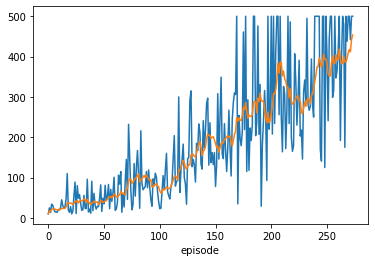

In [10]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('episode')
plt.show()

# save model

In [0]:
model.export('{}_model'.format(env_name))
del model

# load model

In [12]:
deserialized_net = nn.SymbolBlock.imports("{}_model-symbol.json".format(env_name), 
                                          ['data'], 
                                          "{}_model-0000.params".format(env_name))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


# test model

In [0]:
env = gym.make(env_name)
model = deserialized_net

In [14]:
for i_episode in range(10):
  state = env.reset()
  R = 0
  for t in range(1000):
    probs,values = model(nd.array([state]))
    action = np.argmax(probs.asnumpy())
    state, reward, done, info = env.step(action)
    R += reward
    if done:
      break            
  print(i_episode,R)

0 500.0
1 500.0
2 500.0
3 500.0
4 500.0
5 500.0
6 432.0
7 500.0
8 500.0
9 500.0
